# Revenue Management in Continuous Time

Click here for an interactive version of this notebook:-
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/pjohno/MSc-Math-Finance-2018/master?filepath=notebooks%2FMSc%20Project%206%20-%20Revenue%20Management.ipynb)


Here we assume that an agent is trying to sell $n$ assets, and the agent is selling in a monopolist market with no competition. We assume that sales of the asset happen as an inhomogenous Poisson process $N$ where the intesity of the process $\lambda$ is a function of the asset price $p$. Then we define the expected total revenue over the time period from now $t$ until the end of the period $T$ to be
$$
J^u(n,t) = \text{E}\left[\int_t^T p_s dN_s\right]
$$
where the superscript $u$ refers to a particular choice of prices at each time.
If the agent wishes to maximise their expected revenue they must solve
$$
J(n,t) = \sup_u\left\{\text{E}\left[\int_t^T p_s dN_s\right]\right\}
$$
by choosing the set of non-anticipatory prices $u$.

## The HJB Equation

This problem can be formulated as the following HJB equation
$$
\frac{dJ}{dt} + \sup_p\left\{ - \lambda(p)[ J(n,t) - J(n-1,t) ] + \lambda(p) p \right\} = 0
$$
with boundary conditions
$$
J(n,T) = 0
$$
and
$$
J(0,t) = 0.
$$
To find the optimal price $p$, simply differentiate the HJB equation w.r.t the price $p$ to obtain
$$
 -\lambda'[ J(n,t) - J(n-1,t) ] + (\lambda' p + \lambda) =  0
$$
or
$$
 p = J(n,t) - J(n-1,t) - \frac{\lambda}{\lambda'} .
$$

## Numerical Scheme

To solve the problem we use an explicit scheme. First assume that we use fixed grid over time so that
$$
t^j = j\Delta t .
$$
Then approximate the function $J$ by the numerical value $v$ so that 
$$
J(n,t^j) = v_n^j 
$$
and $p$ is 
$$
p(n,t^j) = p_n^j .
$$
The equations to solve then become

$$
p_n^j = v_n^{j+1} - v_{n-1}^{j+1} - \frac{\lambda(p_n^j)}{\lambda'(p_n^j)}
$$

and

$$
 v_n^{j} = (1-\lambda(p_n^j)\Delta t) v_n^{j+1} + (\lambda(p_n^j)\Delta t) v_n^{j+1} + \lambda(p_n^j)\Delta t
$$


Include some standard libraries

In [1]:
#include "msc_project_6.hpp"

Now first define the functional relationship between price and demand. We assign the following form

$$
\lambda(p) = a e^{-\alpha p}
$$

This means that finding $p_n^i$ becomes trivial as $\lambda(p)/\lambda'(p) = -1/\alpha$.

In [2]:
// return the intesity process lambda for a given price (inverse of the price function)
double lambdaIntensity(double price,double a,double alpha)
{
  return a*exp(-alpha*price);
}

Declare parameters in the problem:

In [3]:
// Ns is the number of stock units that may be sold
int Ns;
// parameters for the pricing function
double a,alpha;

// number of timesteps
int K;
// length of time T in which we can sell units
double T,dt;
// create storage to track the optimal sales policy p and value function J
// assume here that J(n,t) = J(n,t^j) = J_n^j
// in code J[n][j] ~~ J_n^j
std::vector<std::vector<double> > Jvalue,optimalPvalue;

and assign them some values

In [4]:
// Ns is the number of stock units that may be sold
Ns=25;
// parameters for the pricing function
a=1000.;alpha=1.;
  
// number of timesteps
K=100;
// length of time T in which we can sell units
T=1.;
// grid variables
dt = T/K;
  
Jvalue.resize(Ns+1,std::vector<double> (K+1));
optimalPvalue.resize(Ns+1,std::vector<double> (K+1));

We can then solve the scheme backwards in time to find the solution of $J$ and $p$.

In [5]:
// assign boundary conditions
// J(n,T)=0
for(int n=0;n<=Ns;n++)
{
Jvalue[n][K]=0.;
}

// J(0,t)=0
for(int j=0;j<=K;j++)
{
Jvalue[0][j]=0.;
}
// assume that selling price is fixed p=1, we solve backwards in time so that
//
//  dJ/dt - lambda(p) ( J(n,t+dt)-J(n-1,t+dt) ) + p lambda(p) = 0
// and in finite differences we have
//  ( J(n,t+dt) - J(n,t) )/dt - lambda(p) ( J(n,t+dt)-J(n-1,t+dt) ) + p lambda(p) = 0
// then we can write
//      J(n,t) = ( 1 - lambda(p) dt ) J(n,t+dt) + ( lambda(p) dt ) J(n-1,t+dt) + p lambda(p)
//      J_n^j = ( 1 - lambda(p) dt ) J_n^{j+1} + ( lambda(p) dt ) J_{n-1}^{j+1} + p lambda(p)
// notice the similarity to binomial tree pricing formula, except q=lambda(p) dt is the probability
//
// At each time step, calculate the Jvalue
for(int j=K-1;j>=0;j--)
{
    for(int n=1;n<=Ns;n++)
    {
        double pStar = Jvalue[n][j+1] - Jvalue[n-1][j+1] + 1./alpha;
        double lambdaStar = lambdaIntensity(pStar,a,alpha);
        Jvalue[n][j]=(1.- lambdaStar*dt) * Jvalue[n][j+1] + 
                        lambdaStar*dt * Jvalue[n-1][j+1] +
                        pStar * lambdaStar * dt;
        optimalPvalue[n][j] = pStar;

    }
}

Now we can plot out the solution $J$

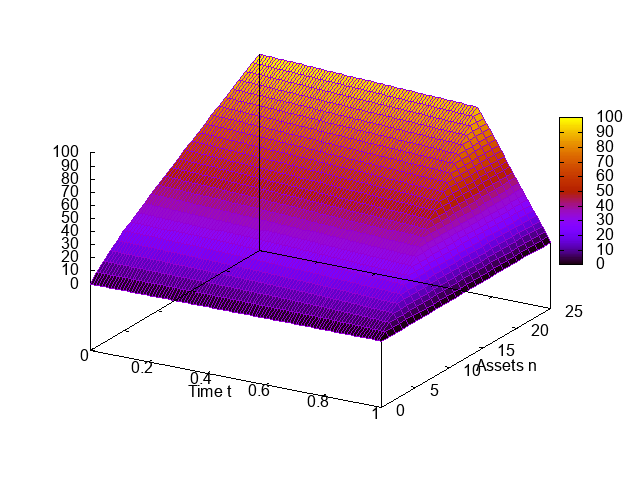

In [6]:
x.resize(Ns+1);
for(int n=0;n<=Ns;n++)
{
    x[n] = n;
}
y.resize(K+1);
for(int j=0;j<=K;j++)
{
    y[j]= j*dt;
}
// plot the figure
{
    // add labels on the x/y axis
    std::stringstream ss("set view 120,60\n"
                         "set xlabel \"Assets n\"\n"
                        "set ylabel \"Time t\"\n"
                        "set pm3d\n");
    // put the plot in figure1
    figure = G.plotData3D(x,y,Jvalue,&ss);
}
// show figure
figure

and $p$

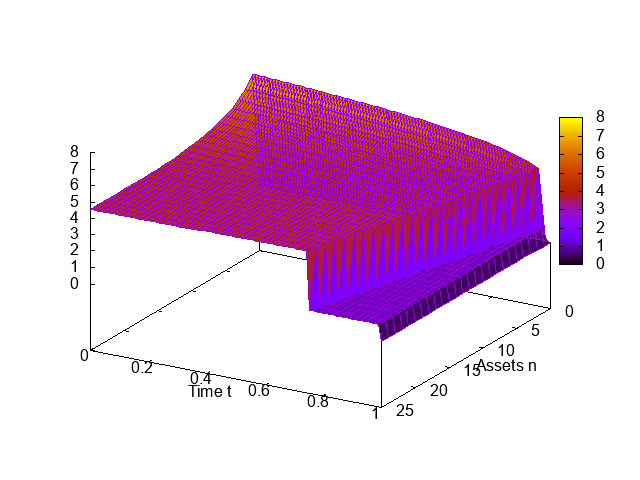

In [7]:
// plot the figure
{
    // add labels on the x/y axis
    std::stringstream ss("set view 60,120\n"
                         "set xlabel \"Assets n\"\n"
                        "set ylabel \"Time t\"\n"
                        "set pm3d\n");
    // put the plot in figure1
    figure = G.plotData3D(x,y,optimalPvalue,&ss);
}
// show figure
figure

See the full code solution on github [click here](https://github.com/pjohno/MSc-Math-Finance-2018/blob/master/main/project-6-revenue-management.cpp).